In [1]:
import pickle
import matplotlib.pyplot as plt
import os
os.chdir('..')
from docker_agent_logger.app.src.AI import *

2023-11-28 12:32:53.975890: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-28 12:32:53.975961: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-28 12:32:53.977191: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-28 12:32:54.091233: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/lucaserf/anaconda3/envs/proteus-env/lib/pyth

In [9]:
!sshpass -p "lTLm#191" scp -r lucaserf@nodeserf2:/var/log/logging_data/ ./data/

Host key verification failed.


In [10]:
with open("./data/logging_data/metrics.pkl", "rb") as f:
    data = pickle.load(f)

with open("./data/logging_data/times.pkl", "rb") as f:
    times = pickle.load(f)

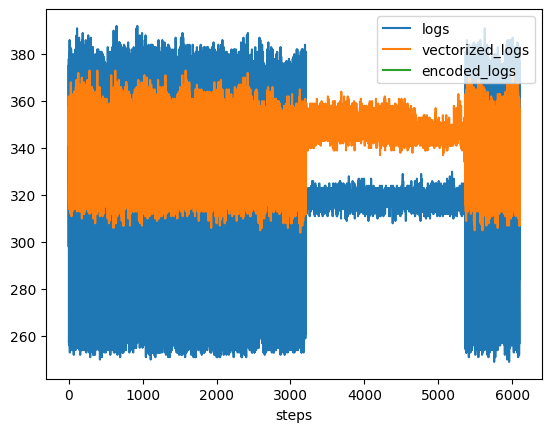

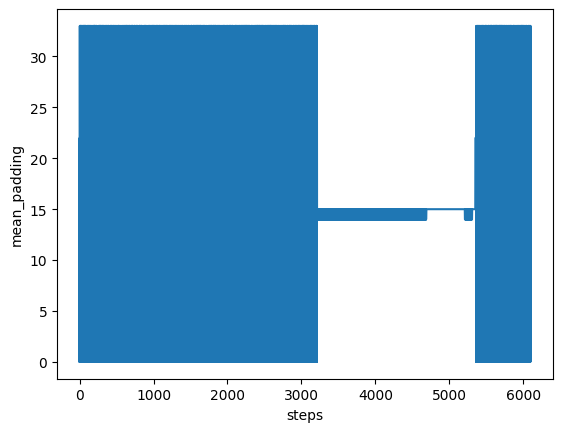

In [11]:
fig, ax = plt.subplots()
for key in ["logs","vectorized_logs","encoded_logs"]:
    ax.plot(data[key], label=key)
    plt.xlabel('steps')
    plt.legend()

plt.show()

for key in ["mean_padding"]:
    fig, ax = plt.subplots()
    plt.xlabel('steps')
    plt.ylabel(key)
    ax.plot(data[key])
    plt.show()

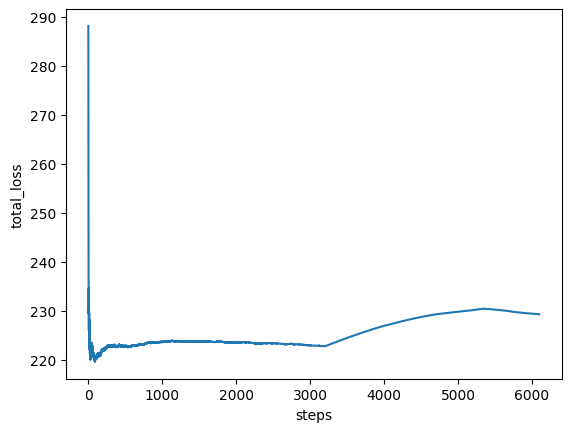

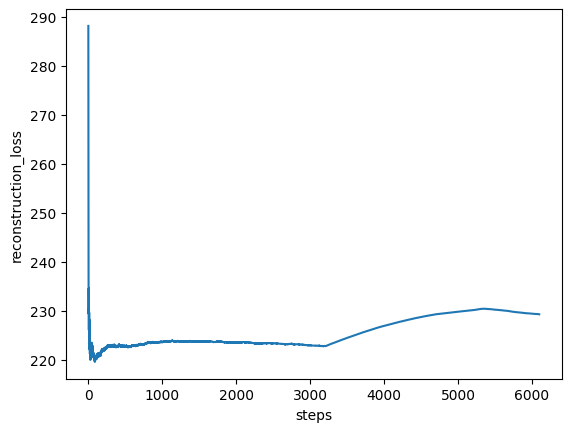

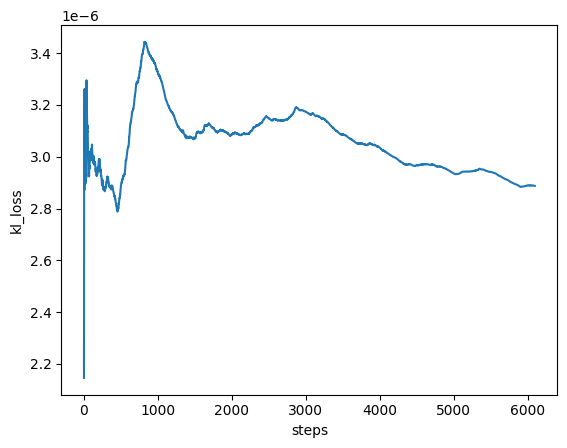

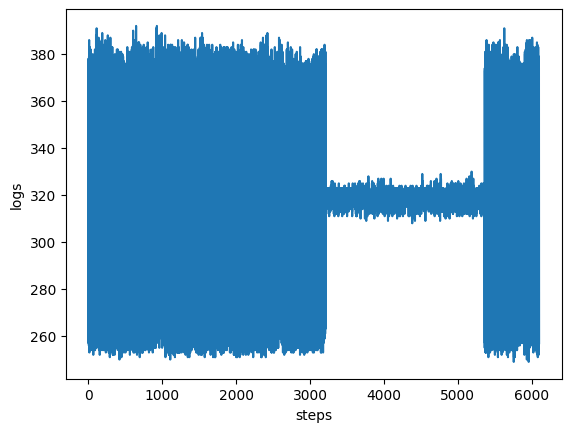

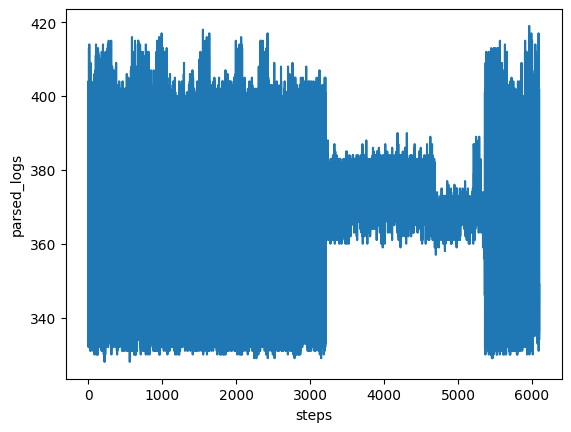

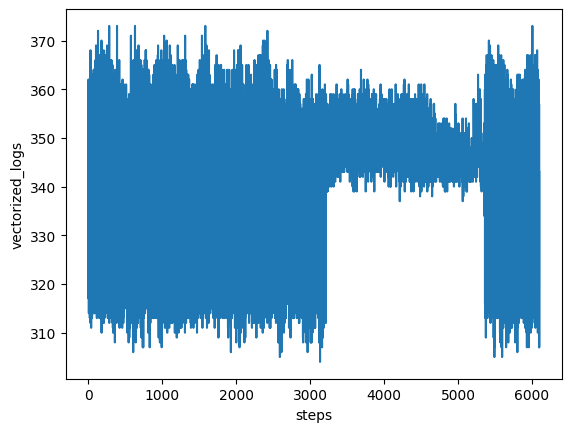

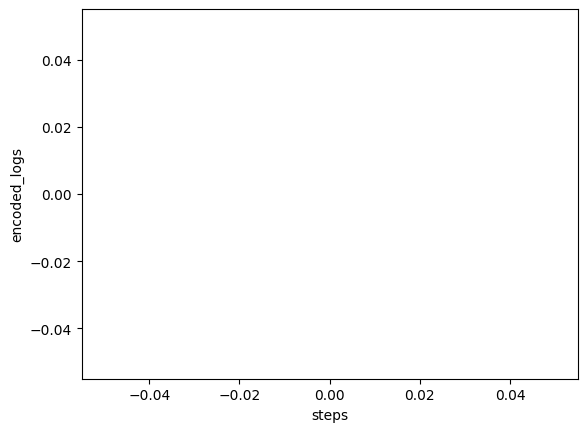

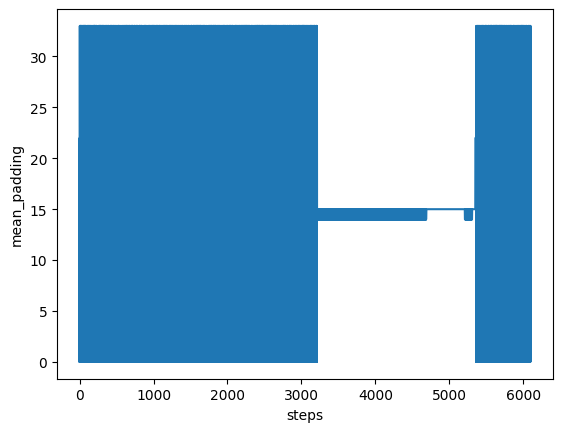

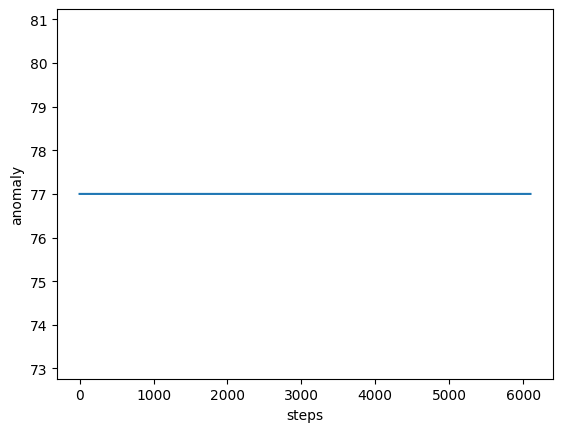

In [12]:
for key in data.keys():
    fig, ax = plt.subplots()
    plt.xlabel('steps')
    plt.ylabel(key)
    ax.plot(data[key])
    plt.show()
        # fig.savefig("")

In [9]:
#testing encoding and decoding
vocab_size = 4000
max_len=60
latent_dim = max_len//2

chkpt = "data_visualization/logging_data/logs_model/"

raw_ds = ( #.filter(lambda x: tf.strings.length(x) > MIN_TRAINING_SEQ_LEN)
    tf.data.TextLineDataset("persistent_volume/data/HDFS_v2/node_logs/hadoop-hdfs-datanode-mesos-01.log")
    .batch(1)
    .shuffle(buffer_size=256)
)

with open("docker_agent_logger/app/logs_tokenizer/vocab.pkl","rb") as f:
    vocab = pickle.load(f)

tokenizer = Tokenizer(vocab=vocab,max_len=max_len)

ds = raw_ds.map(tokenizer.preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(
    tf.data.AUTOTUNE
)

model = Model(vocab_size = vocab_size,latent_dim=latent_dim,embedding_dim=128,max_len = max_len)

model.vae.load_model(chkpt=chkpt)


# z = tf.random.normal(shape=(1, latent_dim))
# vectorized_token = ds.shuffle(buffer_size=256).take(1).as_numpy_iterator().next()

# print(tokenizer.decode(vectorized_token))

# z = model.vae.encode(vectorized_token)

# print(z)

# tokens = model.vae.decode(z)

# print(tokenizer.decode(tokens))



2023-11-14 15:24:32.273141: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 15:24:32.520119: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 15:24:32.520305: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 15:24:32.529282: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 15:24:32.529400: I tensorflow/compile

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 60)]                 0         []                            
 )                                                                                                
                                                                                                  
 input_embedding (TokenAndP  (None, 60, 128)              519680    ['input_word_ids[0][0]']      
 ositionEmbedding)                                                                                
                                                                                                  
 encoding (TransformerEncod  (None, 60, 128)              71828     ['input_embedding[0][0]']     
 er)                                                                                        

2023-11-14 15:25:03.546239: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


100000/100000 [==============================] - 2758s 27ms/step


2023-11-14 16:10:58.230430: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13504693080879762698


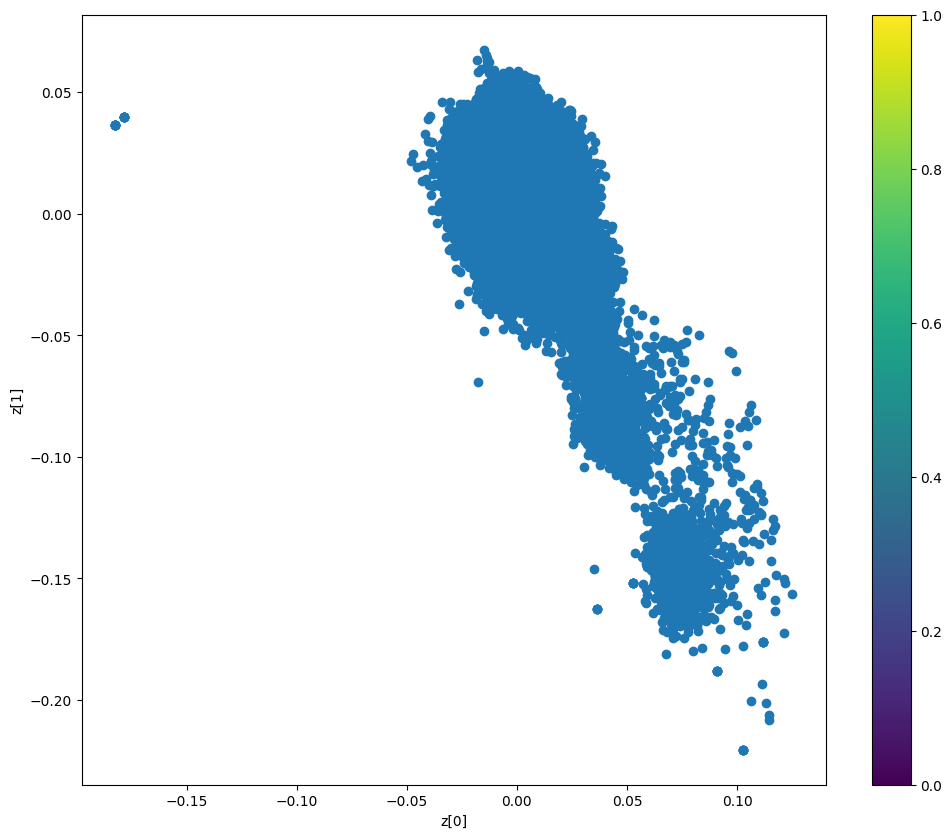

In [10]:
def plot_label_clusters(vae, name,data):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1])
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig("./results/"+name+".png")
    plt.show()

# model = Model(vocab_size = vocab_size,latent_dim=latent_dim,embedding_dim=128,max_len = max_len)

# model.vae.load_model(chkpt=chkpt)
plot_label_clusters(model.vae, "cluster",ds.take(100000))


# for i in range(32):
#     model.vae.load_model(chkpt=chkpt+str(i))

#     plot_label_clusters(model.vae, "cluster"+str(i),ds)

In [49]:
raw_ds = ( #.filter(lambda x: tf.strings.length(x) > MIN_TRAINING_SEQ_LEN)
    tf.data.TextLineDataset("persistent_volume/data/HDFS_v2/node_logs/hadoop-hdfs-datanode-mesos-01.log")
    .batch(64)
)

print(raw_ds.take(1).as_numpy_iterator().next())

[b'2015-12-03 14:37:47,611 INFO org.apache.hadoop.hdfs.server.datanode.DataNode: STARTUP_MSG: '
 b'/************************************************************'
 b'STARTUP_MSG: Starting DataNode'
 b'STARTUP_MSG:   host = mesos-master-1/10.10.34.11'
 b'STARTUP_MSG:   args = []' b'STARTUP_MSG:   version = 2.7.1'
 b'STARTUP_MSG:   classpath = /usr/local/hadoop/etc/hadoop:/usr/local/hadoop/share/hadoop/common/lib/commons-digester-1.8.jar:/usr/local/hadoop/share/hadoop/common/lib/activation-1.1.jar:/usr/local/hadoop/share/hadoop/common/lib/commons-configuration-1.6.jar:/usr/local/hadoop/share/hadoop/common/lib/commons-math3-3.1.1.jar:/usr/local/hadoop/share/hadoop/common/lib/api-util-1.0.0-M20.jar:/usr/local/hadoop/share/hadoop/common/lib/hamcrest-core-1.3.jar:/usr/local/hadoop/share/hadoop/common/lib/jaxb-api-2.2.2.jar:/usr/local/hadoop/share/hadoop/common/lib/slf4j-api-1.7.10.jar:/usr/local/hadoop/share/hadoop/common/lib/jetty-util-6.1.26.jar:/usr/local/hadoop/share/hadoop/common/lib/jer